<a href="https://it-omscholing.nl/locaties/hogeschool-rotterdam/">
<div>
<img src='../../pics/banner.PNG'/>
</div>
<div>
<a href=''><img src='../../pics/miw.PNG'/></a>
<em>Author: Jeroen Boogaard</em>
</div>
</a>

<h1>Practicum Computer Vision</h1>

<h2>Doel: Image Processing voor het vereenvoudigen van <i>Features</i></h2>

<img src='../../pics/land_use.png' length=40% width=40%>

<h3>Imports</h3>

In [2]:
from image_filter import ImageFilter
from PIL import Image
import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import random
#import scimage.measure
import scipy as sp

<h3>Globale variabelen</h3>

In [3]:
riverDirectory = './data/EuroSat/River/'
highwayDirectory = './data/Eurosat/Highway/'

<h3>Data Collection</h3>
<p>
We gebruiken Images uit de <a href="https://www.kaggle.com/datasets/apollo2506/eurosat-dataset">EuroSat dataset</a> die gemaakt zijn met de Sentinel-2 sateliet. Elke image is een 64x64 pixels foto van Europees aardoppervlak op een hoogte van 10 meter. De images zijn te categoriseren in Highway, Industrial, Pasture, PermanentCrop, Residential, River en SeaLake.
</p>
<img src=../../pics/eurosat_overview_small.jpg length=50% width=50%>
<p>
Download <a href="http://madm.dfki.de/files/sentinel/EuroSAT.zip">EuroSAT.zip</a> en kopieer daaruit de directory 2750 naar opdrachten/practica/pics.      
<strong>Voeg het pad naar de directory 2750 toe aan .gitignore zodat je de plaatjes niet naar je remote git repository pusht</strong>
</p>    

<h3>Data Selection</h3>

In [4]:
edgeFiles = list()
 
for filename in os.listdir(riverDirectory):
    imgFile = os.path.join(riverDirectory, filename)

    if ".jpg" in imgFile:
        edgeFiles.append(imgFile)

<h3>Exercise 1</h3>
<p>
    Voeg de directory Highway toe aan de <u>list</u> edgeFiles zodat ook de Highway images worden meegenomen. 
</p>

In [5]:
# Oplossing 
for filename in os.listdir(highwayDirectory):
    imgFile = os.path.join(highwayDirectory, filename)

    if '.jpg' in imgFile:
        edgeFiles.append(imgFile)

<h3>Data Transform</h3>
<p>
Image filters zijn Tensors en om die toe te kunnen passen zetten we de images eerst om naar Tensors m.b.v. Numpy.
</p>    

In [6]:
imageTensors = [ plt.imread(pic).astype(float) for pic in edgeFiles ]
nrOfImages = len(imageTensors)

<h4>Data Normalising</h4>
<p>Om waardes tussen 0 en 1 te vergrijgen, delen we door de maximale pixelwaarde</p>

In [7]:
imageTensors = [ imageTensor/255 for imageTensor in imageTensors ]

<p>
De tensors bevatten alleen de numerieke data van de images, om die te kunnen herleiden tot de oorspronkelijke images hebben we ook een lijst met de corresponderende labels nodig. De labels kunnen we afleiden uit de bestandsnamen.    
</p>    

In [8]:
labelNames, labelNumbers = ([], [])

for i, fileName in enumerate(edgeFiles):
    labelNames.append(fileName.split('/')[4])
    labelNumbers.append(i)

**Controleer de data**

In [9]:
print(f"De eerste Image heeft label {labelNames[0]}")
print(f"De laatste Image heeft label {labelNames[nrOfImages-1]}")

De eerste Image heeft label River_1.jpg
De laatste Image heeft label Highway_999.jpg


<h3>Data visualiseren</h3>

In [10]:
def showImages():
    
    plt.figure(figsize=(10,10))
    
    for i in range(16): #first 4: 1 10 100 1000
        
        # Maak een 2 x 2 raster van Images
        plt.subplot(4, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)        
                
        # Van Tensor terug naar Image
        plt.imshow(imageTensors[i])
        
        # Bijbehorende Imagelabel
        plt.xlabel( f"{labelNames[labelNumbers[i]]} {labelNumbers[i]}" ) 

    plt.show()           

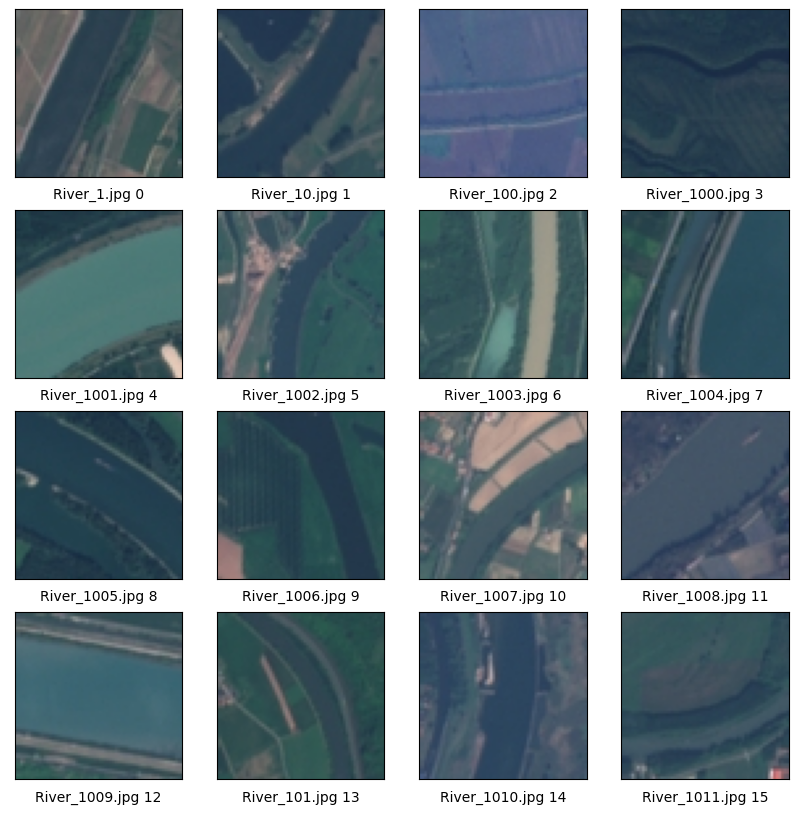

In [11]:
showImages() 

<h3>Exercise 2</h3>
<p>
Maak een nieuwe functie <u>showRandomImages()</u> die <u>16 random</u> images uit de dataset selecteert en weergeeft in een 4 x 4 raster<br>
<strong>Let erop dat bij iedere image het corresponderende label getoond wordt</strong>
</p>

In [12]:
import random

def randomimage(x):
    q = random.randrange(0,x,1)
    return q

randomimage(len(imageTensors))

2896

In [13]:
def showRandomImages():
    
    plt.figure(figsize=(10,10))
    
    for i in range(16): 
        
        plt.subplot(4, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)        
                
        # Van Tensor terug naar Image
        imagerng = randomimage(len(imageTensors))
        plt.imshow(imageTensors[imagerng])
        
        # Bijbehorende Imagelabel
        plt.xlabel( f"{labelNames[labelNumbers[imagerng]]} {labelNumbers[imagerng]}" ) 

    plt.show()     

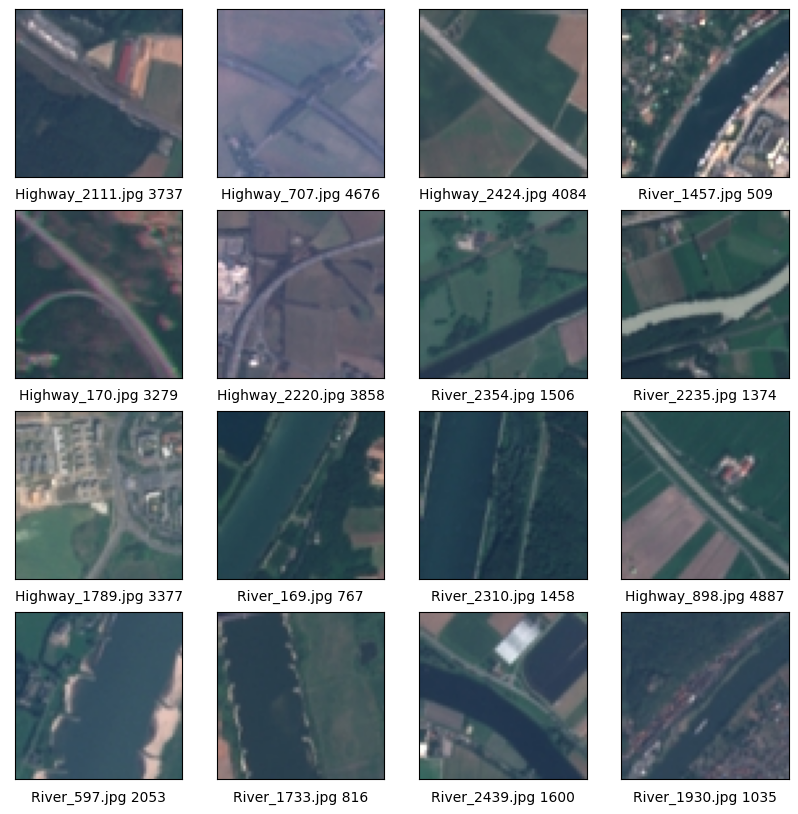

In [14]:
showRandomImages()

<h4>Edge Detection</h4>
<p>
Zowel de Highway en River Images hebben randen die relevant zijn om de auto- of waterweg te kunnen onderscheiden van de directe omgeving. We gaan daarom zoveel mogelijk niet-relevante informatie wegfilteren.    
</p>    

<p>Functie voor het genereren van een subplot</p>

In [15]:
def plotImgs(lImg, rImg):
    plt.style.use('dark_background') 
    plt.rcParams["font.size"] = 12
    plt.rcParams["figure.figsize"] = (12, 7)

    fig, (axL, axR) = plt.subplots(ncols=2, constrained_layout=True)
    fig.suptitle(f"{labelNames[labelNumbers[randInd]]} {labelNumbers[randInd]}")
    imL = axL.imshow(np.clip(lImg, 0, 1), interpolation="none")
    imR = axR.imshow(np.clip(rImg, 0, 1), interpolation="none")    

**Definieer de Image Kernel voor de convolutiefiler**

In [16]:
isoTropicFilter = ImageFilter( 
    np.array (
        [
            [-1, -1, -1], 
            [-1,  8, -1], 
            [-1, -1, -1]
        ]
    ) 
)

**Filter de Image**

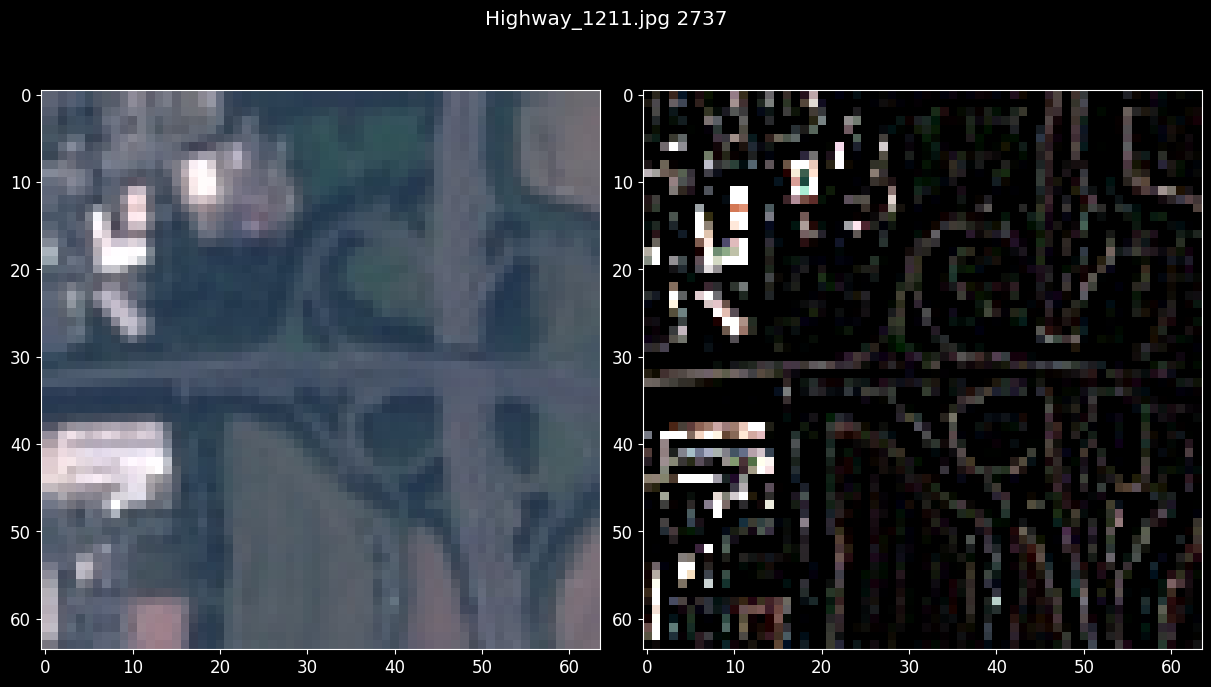

In [17]:
randInd = random.randint(0, nrOfImages)
imgOrg = imageTensors[randInd]
imgFiltered = isoTropicFilter.convolve(imgOrg)

plotImgs(imgOrg, imgFiltered)

<h3>Exercise 3</h3>
<p>
    Maak een 3x3 ImageFilter object <u>horEdgeFilter</u> en voer daarmee een aantal Convoluties uit.<br> 
    Vergelijk de resultaten met die van de Convoluties met de <u>isoTropicFilter</u>
</p>
<p>
    <strong>Tips</strong>
    <ul>
        <li>Op <a href="https://en.wikipedia.org/wiki/Kernel_(image_processing">Wikipedia</a> kun je verschillende filters vinden.</li>
        <li>Schrijf een functie voor <i>batchverwerking</i> op Images.</li>
    </ul>
</p>

In [18]:
#assuming 3x3 horizontal edeg filter
horEdgeFilter = ImageFilter( 
    np.array (
        [
            [ 1,  1,  1], 
            [ 0,  0, 0 ], 
            [-1, -1, -1]
        ]
    ) 
)

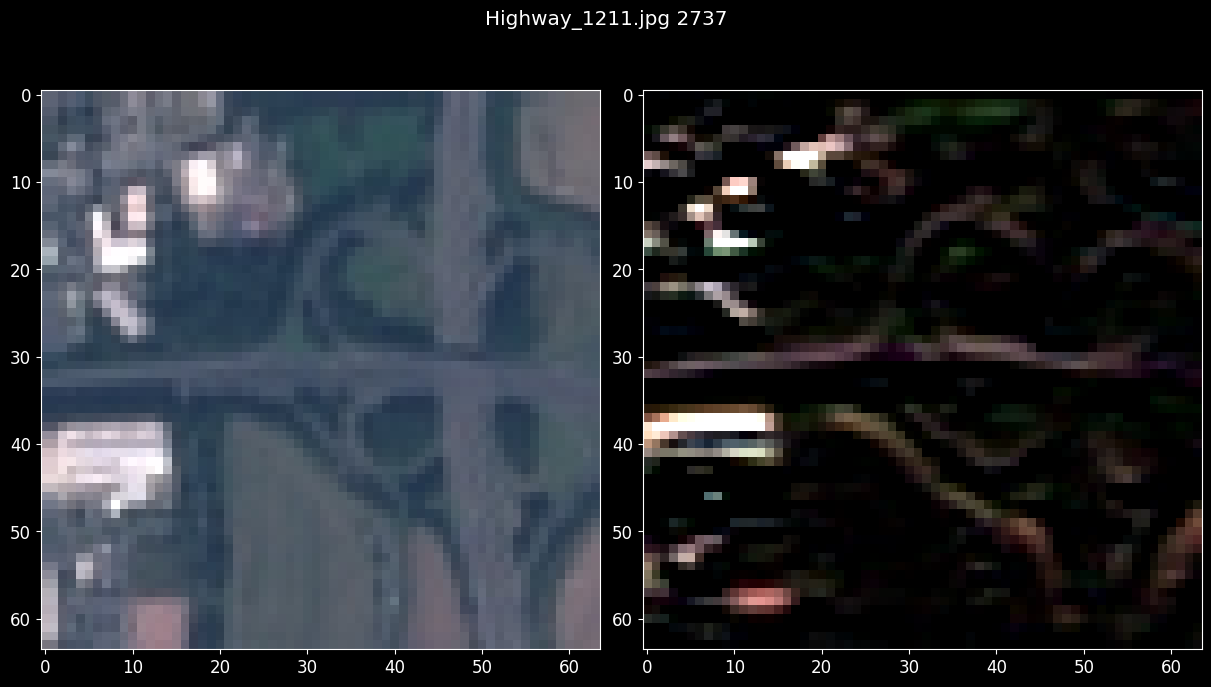

In [19]:
imgOrg = imageTensors[randInd]
imgFiltered = horEdgeFilter.convolve(imgOrg)
plotImgs(imgOrg, imgFiltered)

In [20]:
imgFiltered.shape

(64, 64, 3)

performs worse

<h3>Exercise 4</h3>
<p>
Voeg aan class ImageFilter de methode <u>downSample()</u> toe waarmee een Image gedownsampled kan worden. Maak gebruik van <a href="https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.block_reduce">block_reduce</a> met een grootte van 2.
</p>

In [21]:
imgOrg = imageTensors[randInd]
imgFiltered = horEdgeFilter.downsample(imgOrg)

imgFiltered.shape

(32, 32, 3)

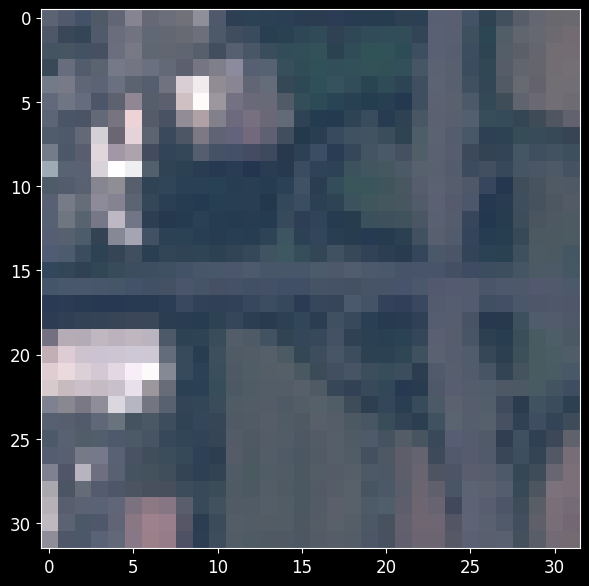

In [22]:
plt#convert from data to image
plt.imshow(imgFiltered, interpolation='nearest')
plt.show()

<h2>References</h2>

[Image Kernels Explained Visuall - Victor Powell](https://setosa.io/ev/image-kernels/)<br>